In [81]:
import os
import sys
import time
import networkx as nx
import scipy.io as sio
import scipy.sparse as sp
from scipy.spatial import distance_matrix
import pandas as pd
import numpy as np

# from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# ## for Palatino and other serif fonts use:
# # rc('font',**{'family':'serif','serif':['Palatino']})
# rc('text', usetex=True)

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.lines import Line2D
from matplotlib.animation import FuncAnimation

import pickle

%matplotlib inline

import re
numeric_const_pattern = r"""
     [-+]? 
     (?:
         (?: \d* \. \d+ )
         |
         (?: \d+ \.? )
     )
     (?: [Ee] [+-]? \d+ ) ?
     """
rx = re.compile(numeric_const_pattern, re.VERBOSE)

from IPython.display import clear_output
from IPython.display import Video

from scipy.stats.stats import pearsonr

print(sns.__version__)

0.13.2


/tmp/ipykernel_62903/2191035762.py:42: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


In [91]:
outdir = './output'
csvfile0 = os.path.join(outdir, 'regression_chebnet_loss_trajectory_s3_sgd_nlap_ba_mix_wm1_tanh_preset1_lr0.001_cons1_v3.csv')
csvfile1 = os.path.join(outdir, 'regression_chebnet_loss_trajectory_s3_dsgd_nlap_ba_mix_wm1_tanh_preset1_lr0.001_cons1_v3.csv')
csvfile2 = os.path.join(outdir, 'regression_chebnet_loss_trajectory_s3_dadam_nlap_ba_mix_wm1_tanh_preset1_lr0.001_cons1_v3.csv')


In [92]:
df0 = pd.read_csv(csvfile0, index_col=0)
df1 = pd.read_csv(csvfile1, index_col=0)
df2 = pd.read_csv(csvfile2, index_col=0)


In [93]:
df0 = df0.rename(columns={
    'epoch': 'epoch',
    'mse_c_train': 'mse_c_train',
    'mse_c_test': 'mse_c_test',
    'mse_d_train': 'train_SGD',
    'mse_d_test': 'test_SGD'
})

df1 = df1.rename(columns={
    'epoch': 'epoch',
    'mse_c_train': 'mse_c_train',
    'mse_c_test': 'mse_c_test',
    'mse_d_train': 'train_DSGD',
    'mse_d_test': 'test_DSGD'
})

df2 = df2.rename(columns={
    'epoch': 'epoch',
    'mse_c_train': 'mse_c_train',
    'mse_c_test': 'mse_c_test',
    'mse_d_train': 'train_DADAM',
    'mse_d_test': 'test_DADAM'
})

In [94]:
df = pd.concat([df0, df1.iloc[:, 3:],
                df2.iloc[:, 3:]
               ], axis=1)

In [96]:
df_train = df[['epoch',
               'mse_c_train', 'train_SGD', 'train_DSGD', 'train_DADAM']]
df_test = df[['epoch',
              'mse_c_test', 'test_SGD', 'test_DSGD', 'test_DADAM']]

In [97]:
df

,epoch,mse_c_train,mse_c_test,train_SGD,test_SGD,corrcoef,train_DSGD,test_DSGD,corrcoef,train_DADAM,test_DADAM,corrcoef,train_DAMS,test_DAMS,corrcoef
0,0.0,0.267839,0.229519,0.264238,0.224169,0.170942,0.236397,0.183937,0.170942,0.292037,0.289098,0.170942,2.013717,2.437926,0.170942
1,1.0,0.198439,0.155417,0.192759,0.149746,0.170942,0.149490,0.134083,0.170942,0.273340,0.270670,0.170942,2.390117,2.368766,0.170942
2,2.0,0.139244,0.109233,0.134535,0.107439,0.170942,0.112413,0.112949,0.170942,0.255731,0.253499,0.170942,2.280986,2.203033,0.170942
3,3.0,0.101263,0.089942,0.099139,0.089898,0.170942,0.093345,0.102293,0.170942,0.238966,0.236161,0.170942,2.146125,2.061386,0.170942
4,4.0,0.083764,0.082082,0.082715,0.081523,0.170942,0.082710,0.095501,0.170942,0.222860,0.219367,0.170942,2.012209,1.934859,0.170942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608,NaN,NaN,NaN,NaN,NaN,NaN,0.013679,0.022708,0.170942,NaN,NaN,NaN,NaN,NaN,NaN
609,NaN,NaN,NaN,NaN,NaN,NaN,0.013577,0.023044,0.170942,NaN,NaN,NaN,NaN,NaN,NaN
610,NaN,NaN,NaN,NaN,NaN,NaN,0.013623,0.023145,0.170942,NaN,NaN,NaN,NaN,NaN,NaN
611,NaN,NaN,NaN,NaN,NaN,NaN,0.013629,0.022021,0.170942,NaN,NaN,NaN,NaN,NaN,NaN


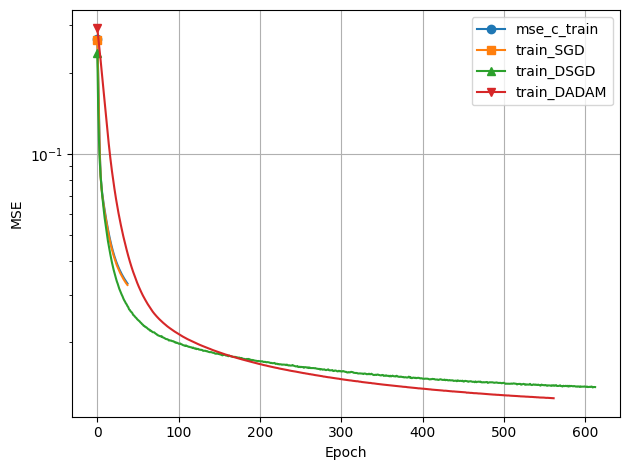

In [98]:
# Define a list of markers to use
markers = ['o', 's', '^', 'v', 'x', 'D', '>', '<', '*', '+']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
logy=True
fig, ax = plt.subplots()
# Plot all columns with different markers on the same plot
for i in range(1, len(df_train.columns)):
    # col_train, col_test = df_train.iloc[:, [0, i]], df_train.iloc[:, [0, i+1]]
    marker_train = markers[i-1 % len(markers)]  # Cycle through markers
    # marker_test = markers[i % len(markers)] 
    df_train.iloc[:, i].plot(x='epoch', marker=marker_train, markevery=900, color=colors[i-1], ax=ax, logy=logy)
    # col_test.plot(x='epoch', marker=marker_test, markevery=(i+3)*1, color=colors[i-1], ax=ax, logy=logy)
plt.grid('minor')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(ncol=1)
# plt.xlim([500, 1000])
plt.tight_layout()
# plt.savefig('output/fig/train_sgd_nlap_ba_kite.jpg')
plt.show()